# **ISSCC 2026 Code-a-Chip Challenge**
# **Automated Design and Optimization of Current-Mode Logic Chains / Dividers**
## Author: Adham M. Elhelly

📧 adhamacc1@gmail.com  
🔗 [GitHub](https://github.com/adhammo) · [LinkedIn](https://www.linkedin.com/in/adhamheli/)

---

The notebook flow is inspired by the ISSCC 2025 Code-a-Chip submission by [alecadair](https://github.com/alecadair).

Please feel free to reach out!

**Work licensed under Apache 2.0**

Details of the Apache 2.0 license can be found in the LICENSE file in the top-level directory.

---

Welcome to this **ISSCC 2026 Code-a-Chip Challenge** notebook!  
This notebook demonstrates an automated design and optimization flow for a **chain of current-mode logic (CML) circuits**, with examples of **Divide-by-2** and **Divide-by-2/3** circuits, using the **C/ID method** implemented in the **open-source Skywater130-A PDK**.

The **C/ID** methodology is an extension of the **gm/ID** design methodology.  
It incorporates dynamic behavior and self-loading into the **gm/ID** framework.

## **Tool Installation**

Install needed python libraries to run the flow

In [ ]:
# Update pip
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# Install needed python libraries
!pip install matplotlib
!pip install pandas
!pip install pymoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 18.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [pymoo]


## **Import Python Libraries**

In [ ]:
# Import basic libraries and matplotlib graphing libraries
import sys, os, shutil, re, math, subprocess, pickle
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

## **Install NGSPICE (if needed)**

If magic is not in $PATH then install and build ngspice

In [ ]:
if shutil.which("ngspice"):
  print("ngspice is available in $PATH.")
else:
  !wget https://altushost-swe.dl.sourceforge.net/project/ngspice/ng-spice-rework/45.2/ngspice-45.2.tar.gz
  !tar -xzf ngspice-45.2.tar.gz
  %cd ngspice-45.2/
  !./configure --with-x=no
  !make
  !sudo make install
  %cd ..

--2025-11-04 08:28:06--  https://altushost-swe.dl.sourceforge.net/project/ngspice/ng-spice-rework/45.2/ngspice-45.2.tar.gz
Resolving altushost-swe.dl.sourceforge.net (altushost-swe.dl.sourceforge.net)... 79.142.76.130
Connecting to altushost-swe.dl.sourceforge.net (altushost-swe.dl.sourceforge.net)|79.142.76.130|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.sourceforge.net/project/ngspice/ng-spice-rework/45.2/ngspice-45.2.tar.gz [following]
--2025-11-04 08:28:07--  https://downloads.sourceforge.net/project/ngspice/ng-spice-rework/45.2/ngspice-45.2.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:c95, ...
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|104.18.13.149|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pilotfiber.dl.sourceforge.net/project/ngspice/ng-spice-rework/45.2/ngspice-45.2.tar.g

## **Install MAGIC (if needed)**

If magic is not in $PATH then install and build magic

In [ ]:
if shutil.which("magic"):
  print("magic is available in $PATH.")
else:
  !git clone https://github.com/RTimothyEdwards/magic.git
  %cd magic
  !./configure
  !make
  !sudo make install
  %cd ..

Cloning into 'magic'...
remote: Enumerating objects: 17612, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 17612 (delta 323), reused 334 (delta 290), pack-reused 17177 (from 2)
Receiving objects: 100% (17612/17612), 10.78 MiB | 19.47 MiB/s, done.
Resolving deltas: 100% (11645/11645), done.
/content/magic
checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking target system type... x86_64-pc-linux-gnu
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking how to run the C preprocessor... gcc -E
checking for g++..

## **Install PDK (if needed)**

If $PDK_ROOT is not set then clone the Skywater130 PDK and build it

In [ ]:
if 'PDK_ROOT' in os.environ:
  print(f"PDK_ROOT is set to: {os.environ['PDK_ROOT']}")
else:
  !git clone https://github.com/RTimothyEdwards/open_pdks
  %cd open_pdks
  !./configure --enable-sky130-pdk
  !make
  %cd sky130/sky130A
  os.environ['PDK_ROOT'] = os.getcwd()
  %cd ../../..

Streaming output truncated to the last 5000 lines.
Reading "sky130_fd_io__tk_em1s_CDNS_52468879185978".
Saving contents of cell sky130_fd_io__tk_em1s_CDNS_52468879185978
Reading "PYL1_CDNS_52468879185447".
Saving contents of cell PYL1_CDNS_52468879185447
Reading "pfet_CDNS_524688791851093".
Saving contents of cell pfet_CDNS_524688791851093
Reading "pfet_CDNS_524688791851092".
Saving contents of cell pfet_CDNS_524688791851092
Reading "nDFres_CDNS_524688791851094".
Saving contents of cell nDFres_CDNS_524688791851094
Reading "M1M2_CDNS_524688791851084".
Saving contents of cell M1M2_CDNS_524688791851084
Reading "L1M1_CDNS_52468879185956".
Saving contents of cell L1M1_CDNS_52468879185956
Reading "M1M2_CDNS_52468879185299".
Saving contents of cell M1M2_CDNS_52468879185299
Reading "M1M2_CDNS_524688791851078".
Saving contents of cell M1M2_CDNS_524688791851078
Reading "L1M1_CDNS_524688791851064".
Saving contents of cell L1M1_CDNS_524688791851064
Reading "M1M2_CDNS_52468879185204".
Saving conten

## **Clone Current Mode Logic Dividers Synthesis Repository**

This Repository contains scripts, templates, and characterizations to run the flow in this notebook.

In [ ]:
!rm -rf CML-DIV-Synthesis
!git clone https://github.com/adhammo/CML-DIV-Synthesis
%cd CML-DIV-Synthesis

/content
Cloning into 'CML-DIV-Synthesis'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 70 (delta 31), reused 54 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 66.60 KiB | 5.12 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/CML-DIV-Synthesis


## **CML Testbench for Lookup Table Generation**
CML Testbench netlist template can be found under characterization/cml_char_template.cir
The testbench sweeps both Vswing and ID/W of devices and records:
* Small-signal transconductance of quiscent point
* Small-signal transconductance and capacitances of full-steering point
* Large-signal Voltage Swing Ratio in full-steering pair
* Saturation Margin (Vds-Vdssat) in full-steered configuration

![image.png](images\char_tb.png)

### **Lookup Table Generation**

This step is optional in the flow. Lookup tables for the Skywater130A process come pre-packaged in the characterization/sky130 directory.
Running the following cell will recreate the lookup tables in this directory and results may be different than what is tested.

**When initially running this notebook is recommended to not recreate lookup tables.**
**By default the function call at the bottom of this cell is commented out. This can be uncommented to run lookup table generation.**

---


In [ ]:
def fix_data_line(text):
    text = re.sub(r"^\s+", "", text, flags=re.MULTILINE)
    text = re.sub(r"[ \t]+", ",", text)
    return text


def create_netlist_from_template(netlist_template, length, corner, temperature):
    if os.path.exists(netlist_template):
        with open(netlist_template, "r") as net_temp:
            netlist_data = net_temp.read()
        length_str = str(length)
        netlist_data = netlist_data.replace("_PDK_ROOT", os.environ["PDK_ROOT"])
        netlist_data = netlist_data.replace("_VDD", "1.8")
        netlist_data = netlist_data.replace("_LENGTH", length_str)
        netlist_data = netlist_data.replace("_TEMPERATURE", temperature)
        netlist_data = netlist_data.replace("_CORNER", corner)
        return netlist_data

def generate_sky130_LUT():
    netlist_template_file = "characterization/cml_char_template.cir"

    # remove for-loop for now (typical)

    model = "01v8_lvt"
    corner = "tt"
    temp = "25"
    length = ".150"

    print("Creating netlist...")
    edited_netlist = create_netlist_from_template(
        netlist_template=netlist_template_file,
        length=length,
        corner=corner,
        temperature=temp,
    )
    prefix = model + "_" + str(length.replace(".", "")) + "_" + corner + "_" + temp
    netlist_name = prefix + ".cir"
    result_name = prefix + ".csv"
    with open(netlist_name, "w") as file:
        file.write(edited_netlist)

    print("Running characterization...")
    os.system("ngspice " + netlist_name)

    print("Reading results...")
    if os.path.exists("cml_char_op.csv") and os.path.exists("cml_char_sp.csv"):
        with open("cml_char_op.csv", "r") as file:
            op_lines = file.readlines()
        with open("cml_char_sp.csv", "r") as file:
            sp_lines = file.readlines()
        os.system("rm cml_char_op.csv")
        os.system("rm cml_char_sp.csv")

    print("Writing results...")
    with open(result_name, "w") as file:
        for i, (op_line, sp_line) in enumerate(zip(op_lines, sp_lines)):
            op_line = fix_data_line(op_line)
            sp_line = fix_data_line(sp_line)
            file.write(f'{",".join(op_line.strip().split(",")[1::2])},{",".join(sp_line.strip().split(",")[5::2])}\n')

    os.system("mkdir characterization/sky130")
    os.system("mv " + netlist_name + f" characterization/sky130/{netlist_name}")
    os.system("mv " + result_name + f" characterization/sky130/{result_name}")

# generate_sky130_LUT()

## **Current Mode Logic LUT: Read device LUT and Swap ID/W for Av**

Read device LUT and create CML LUT by Finding the ID/W that achieves the following equation:

$\frac{gm}{Id}-Av*\frac{gds}{Id} = \frac{2Av}{Vsw}$

In all codes, all the parameters in the lookup table are divided by ID I.E. "gm" = gm/Id, "cgs" = cgs/Id

In [ ]:
# read LUT
lut_df = pd.read_csv("characterization/sky130/01v8_lvt_150_tt_25.csv", skipinitialspace=True)

# create DOFs
av_vals = np.linspace(0.1, 2, 20)
vsw_vals = lut_df["vsw"].drop_duplicates()

# holder for CML LUT after swap
data_cml = {
    "av": np.repeat(av_vals, vsw_vals.size),
    "vsw": np.tile(vsw_vals, av_vals.size),
    "idw": [],
    "vgs": [],
    "meas_av": [],
    "gm": [],
    "gds": [],
    "gm_full": [],
    "vsr": [],
    "margin": [],
    "margin_vth": [],
    "cgs": [],
    "cgd": [],
    "cdb": [],
    "csb": [],
}

# swap LUT to use DOFs (Av, Vsw)
# for each Av and Vsw:  1. get ID/W that solves the equation
#                       2. interpolate LUT at found ID/W
for av in av_vals:
    for vsw in vsw_vals:
        df_vsw = lut_df[lut_df["vsw"] == vsw]
        vals = df_vsw["gm"] - av * df_vsw["gds"]
        equ = 2 * av / vsw
        # vals vs. Id/W is in descending order hence the [::-1]
        data_cml["idw"].append(np.interp(equ, vals[::-1], df_vsw["idw"][::-1]))
        data_cml["vgs"].append(np.interp(equ, vals[::-1], df_vsw["vgs"][::-1]))
        data_cml["meas_av"].append(np.interp(equ, vals[::-1], (df_vsw["gm"]*(df_vsw["vsw"]/2)*(1+df_vsw["gds"]*(df_vsw["vsw"]/2)))[::-1]))
        data_cml["gm"].append(np.interp(equ, vals[::-1], df_vsw["gm"][::-1]))
        data_cml["gds"].append(np.interp(equ, vals[::-1], df_vsw["gds"][::-1]))
        data_cml["gm_full"].append(np.interp(equ, vals[::-1], df_vsw["gm_full"][::-1]))
        data_cml["vsr"].append(np.interp(equ, vals[::-1], df_vsw["vsr"][::-1]))
        data_cml["margin"].append(np.interp(equ, vals[::-1], df_vsw["margin"][::-1]))
        data_cml["margin_vth"].append(np.interp(equ, vals[::-1], df_vsw["margin_vth"][::-1]))
        data_cml["cgs"].append(np.interp(equ, vals[::-1], df_vsw["cgs"][::-1]))
        data_cml["cgd"].append(np.interp(equ, vals[::-1], df_vsw["cgd"][::-1]))
        data_cml["cdb"].append(np.interp(equ, vals[::-1], df_vsw["cdb"][::-1]))
        data_cml["csb"].append(np.interp(equ, vals[::-1], df_vsw["csb"][::-1]))

cml_df = pd.DataFrame(data_cml)

### **Check CML LUT after swap**


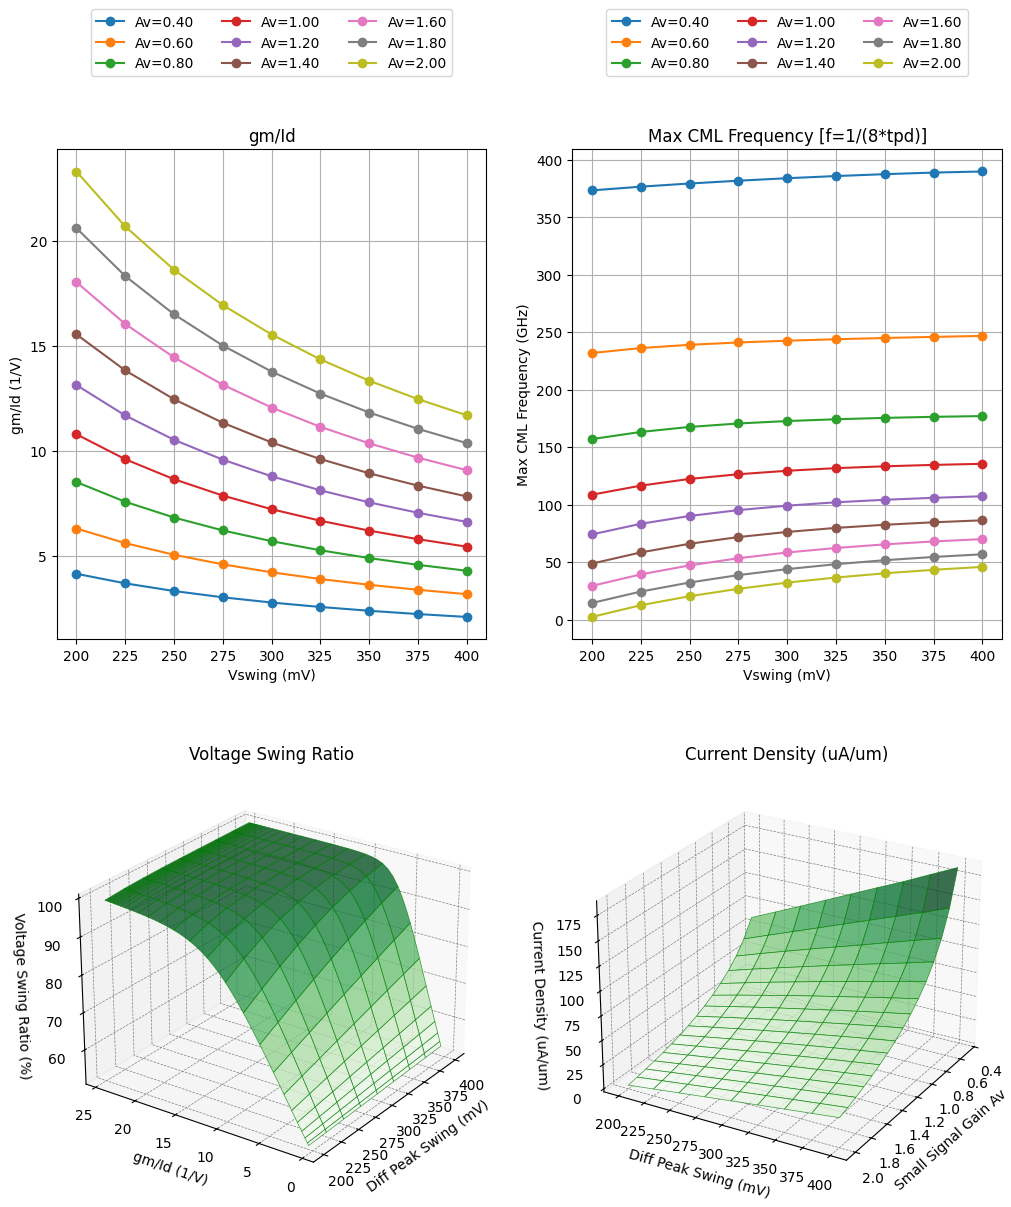

In [ ]:
fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223, projection="3d")
ax4 = fig.add_subplot(224, projection="3d")
for av in av_vals[3::2]:
    df_av = cml_df[cml_df["av"] == av]
    ax1.plot(df_av["vsw"]*1e3, df_av["gm"], marker="o", label=f"Av={av:.2f}")
    ax2.plot(df_av["vsw"]*1e3, 1/(0.69*3*(df_av["cgs"]+2*df_av["cgd"]+df_av["cdb"])*df_av["vsw"])*1e-9, marker="o", label=f"Av={av:.2f}")
ax1.set_xlabel("Vswing (mV)")
ax1.set_ylabel("gm/Id (1/V)")
ax1.set_title("gm/Id")
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3)
ax1.grid(True)
ax2.set_xlabel("Vswing (mV)")
ax2.set_ylabel("Max CML Frequency (GHz)")
ax2.set_title("Max CML Frequency [f=1/(8*tpd)]")
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3)
ax2.grid(True)
ax3.plot_surface(
    np.reshape(lut_df["vsw"].to_numpy(), (lut_df["vsw"].drop_duplicates().size, -1))*1e3,
    np.reshape(lut_df["gm"].to_numpy(), (lut_df["vsw"].drop_duplicates().size, -1)),
    np.reshape(lut_df["vsr"].to_numpy(), (lut_df["vsw"].drop_duplicates().size, -1)),
    lw=0.5,
    alpha=0.77,
    label="legend_str",
    cmap='Greens',
    cstride=3,
    rstride=1,
    edgecolor="green",
)
ax3.set_xlabel("Diff Peak Swing (mV)")
ax3.set_ylabel("gm/Id (1/V)")
ax3.set_zlabel("Voltage Swing Ratio (%)")
ax3.xaxis._axinfo["grid"].update(color="gray", linestyle="--", linewidth=0.5)
ax3.yaxis._axinfo["grid"].update(color="gray", linestyle="--", linewidth=0.5)
ax3.zaxis._axinfo["grid"].update(color="gray", linestyle="--", linewidth=0.5)
ax3.view_init(elev=25, azim=215)
ax3.set_title("Voltage Swing Ratio")
ax4.plot_surface(
    np.reshape(cml_df["av"].to_numpy(), (-1, cml_df["vsw"].drop_duplicates().size))[4::1,:],
    np.reshape(cml_df["vsw"].to_numpy(), (-1, cml_df["vsw"].drop_duplicates().size))[4::1,:]*1e3,
    np.reshape(cml_df["idw"].to_numpy(), (-1, cml_df["vsw"].drop_duplicates().size))[4::1,:],
    lw=0.5,
    alpha=0.77,
    label="legend_str",
    cmap='Greens',
    cstride=1,
    rstride=1,
    edgecolor="green",
)
ax4.set_xlabel("Small Signal Gain Av")
ax4.set_ylabel("Diff Peak Swing (mV)")
ax4.set_zlabel("Current Density (uA/um)")
ax4.xaxis._axinfo["grid"].update(color="gray", linestyle="--", linewidth=0.5)
ax4.yaxis._axinfo["grid"].update(color="gray", linestyle="--", linewidth=0.5)
ax4.zaxis._axinfo["grid"].update(color="gray", linestyle="--", linewidth=0.5)
ax4.view_init(elev=25, azim=30)
ax4.set_title("Current Density (uA/um)")
plt.subplots_adjust(right=0.8)
plt.show()

## **Source Follower LUT: Read device LUT and Swap ID/W for gm/Id**

Read device LUT and create SF LUT by swapping ID/W to gm/Id:

In all codes, all the parameters in the lookup table are divided by ID I.E. "gm" = gm/Id, "cgs" = cgs/Id

In [ ]:
# read LUT
lut_df = pd.read_csv("characterization/sky130/01v8_lvt_150_tt_25.csv", skipinitialspace=True)

# create DOFs
gmid_vals = np.linspace(1, 25, 25)
vsw_vals = lut_df["vsw"].drop_duplicates()

# holder for SF LUT after swap
data_sf = {
    "gmid": np.repeat(gmid_vals, vsw_vals.size),
    "vsw": np.tile(vsw_vals, gmid_vals.size),
    "idw": [],
    "vgs": [],
    "av": [],
    "gm": [],
    "gds": [],
    "cgs": [],
    "cgd": [],
    "cdb": [],
    "csb": [],
}

# swap LUT to use DOFs (gm/Id, Vsw)
for gmid in gmid_vals:
    for vsw in vsw_vals:
        df_vsw = lut_df[lut_df["vsw"] == vsw]
        vals = df_vsw["gm"]
        equ = gmid
        # vals vs. Id/W is in descending order hence the [::-1]
        data_sf["idw"].append(np.interp(equ, vals[::-1], df_vsw["idw"][::-1]))
        data_sf["vgs"].append(np.interp(equ, vals[::-1], df_vsw["vgs"][::-1]))
        data_sf["av"].append(np.interp(equ, vals[::-1], (1 / (1 + df_vsw["gds"] / df_vsw["gm"]))[::-1]))
        data_sf["gm"].append(np.interp(equ, vals[::-1], df_vsw["gm"][::-1]))
        data_sf["gds"].append(np.interp(equ, vals[::-1], df_vsw["gds"][::-1]))
        # cgs in device LUT is normalized to 2*Id hence the multiplying by 2
        data_sf["cgs"].append(np.interp(equ, vals[::-1], 2 * df_vsw["cgs"][::-1]))
        data_sf["cgd"].append(np.interp(equ, vals[::-1], 2 * df_vsw["cgd"][::-1]))
        data_sf["cdb"].append(np.interp(equ, vals[::-1], 2 * df_vsw["cdb"][::-1]))
        data_sf["csb"].append(np.interp(equ, vals[::-1], 2 * df_vsw["csb"][::-1]))

sf_df = pd.DataFrame(data_sf)

### **Check CML LUT after swap**


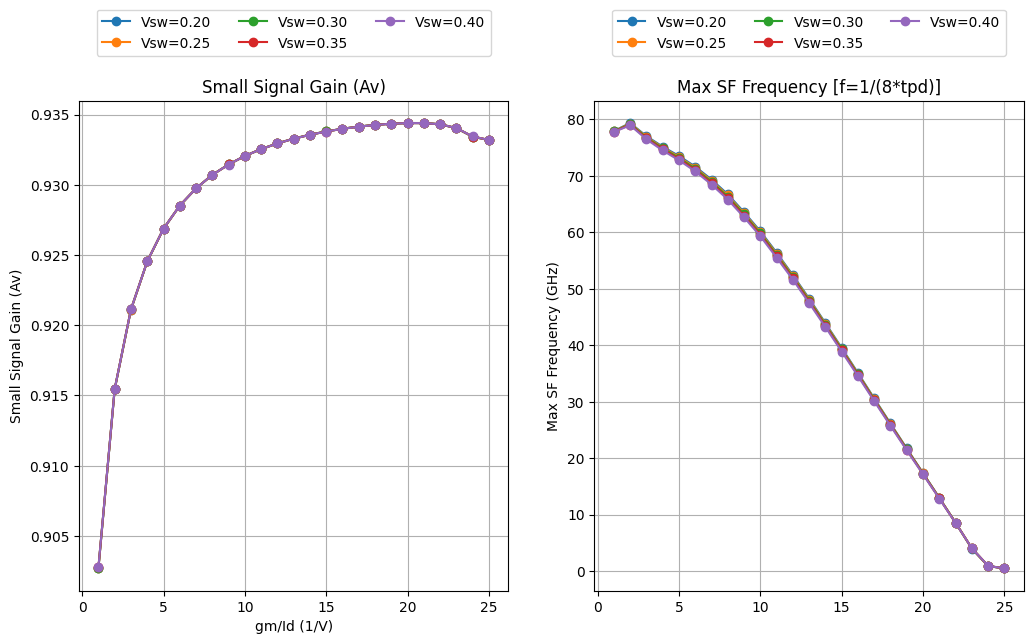

In [ ]:
fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
for vsw in vsw_vals[0::2]:
    df_vsw = sf_df[sf_df["vsw"] == vsw]
    ax1.plot(df_vsw["gmid"], df_vsw["av"], marker="o", label=f"Vsw={vsw:.2f}")
    ax2.plot(df_vsw["gmid"], 1/(0.69*8*(df_vsw["cgs"]+df_vsw["cgd"])/df_vsw["gm"])*1e-9, marker="o", label=f"Vsw={vsw:.2f}")
ax1.set_xlabel("gm/Id (1/V)")
ax1.set_ylabel("Small Signal Gain (Av)")
ax1.set_title("Small Signal Gain (Av)")
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
ax1.grid(True)
ax1.set_xlabel("gm/Id (1/V)")
ax2.set_ylabel("Max SF Frequency (GHz)")
ax2.set_title("Max SF Frequency [f=1/(8*tpd)]")
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
ax2.grid(True)
plt.subplots_adjust(right=0.8)
plt.show()

## Setup Optimization Interpolaters

The following functions creates the interpolaters used for the following optimization problems.


In [ ]:
def create_interpolators(x, y, z):
    return sp.interpolate.RegularGridInterpolator(
        (lut_df[x].drop_duplicates(), lut_df[y].drop_duplicates()),
        np.reshape(lut_df[z].to_numpy(), (-1, lut_df[y].drop_duplicates().size)),
    )

def create_cml_interpolators(x, y, z):
    return sp.interpolate.RegularGridInterpolator(
        (cml_df[x].drop_duplicates(), cml_df[y].drop_duplicates()),
        np.reshape(cml_df[z].to_numpy(), (-1, cml_df[y].drop_duplicates().size)),
    )

def create_sf_interpolators(x, y, z):
    return sp.interpolate.RegularGridInterpolator(
        (sf_df[x].drop_duplicates(), sf_df[y].drop_duplicates()),
        np.reshape(sf_df[z].to_numpy(), (-1, sf_df[y].drop_duplicates().size)),
    )

interp_vsr = create_interpolators("vsw", "idw", "vsr")
interp_cml_idw = create_cml_interpolators("av", "vsw", "idw")
interp_cml_gm_full = create_cml_interpolators("av", "vsw", "gm_full")
interp_cml_cgs = create_cml_interpolators("av", "vsw", "cgs")
interp_cml_cgd = create_cml_interpolators("av", "vsw", "cgd")
interp_cml_cdb = create_cml_interpolators("av", "vsw", "cdb")
interp_cml_csb = create_cml_interpolators("av", "vsw", "csb")
interp_sf_idw = create_sf_interpolators("gmid", "vsw", "idw")
interp_sf_gm = create_sf_interpolators("gmid", "vsw", "gm")
interp_sf_gds = create_sf_interpolators("gmid", "vsw", "gds")
interp_sf_cgs = create_sf_interpolators("gmid", "vsw", "cgs")
interp_sf_cgd = create_sf_interpolators("gmid", "vsw", "cgd")
interp_sf_cdb = create_sf_interpolators("gmid", "vsw", "cdb")
interp_sf_csb = create_sf_interpolators("gmid", "vsw", "csb")

## Setup Evaluation Functions for Each Circuit

The following functions evaluates many needed circuits parameters for the optimization.

The main used circuits are Latch, And/Or Gate, Source Follower.


In [ ]:
def eval_sf_idw(sf, vsw=0.3):
    idw = interp_sf_idw((sf["gmid"], vsw))
    return {**sf, "idw": idw}

def eval_sf_av(sf, vsw=0.3):
    av = 1 / (1 + interp_sf_gds((sf["gmid"], vsw)) / interp_sf_gm((sf["gmid"], vsw)))
    return {**sf, "av": av}

def eval_sf_caps(sf, vsw=0.3):
    gm = interp_sf_gm((sf["gmid"], vsw))
    cgs = interp_sf_cgs((sf["gmid"], vsw))
    cgd = interp_sf_cgd((sf["gmid"], vsw))
    cdb = interp_sf_cdb((sf["gmid"], vsw))
    csb = interp_sf_csb((sf["gmid"], vsw))
    return {
        **sf,
        "gm": gm,
        "cgs": cgs,
        "cgd": cgd,
        "cdb": cdb,
        "csb": csb,
    }

# calculate iss from (tcq=tcq_intrinsic+cload/[iss*(gm/iss)])
# as iss=cload/[(gm/id)*(tcq-tcq_intrinsic)]
def calc_sf_iss(sf, cload, tcq):
    gm = sf["gm"]
    cgs = sf["cgs"]
    csb = sf["csb"]
    iss = cload / (gm * ((tcq / 0.69) - ((csb + cgs) / gm)))
    return {
        **sf,
        "iss": iss,
    }

def eval_latch_idw(latch):
    idw_in, idw_clk, idw_lat = interp_cml_idw(
        [
            (latch["av_in"], latch["vsw"]),
            (latch["av_clk"], latch["vsw"]),
            (latch["av_lat"], latch["vsw"]),
        ]
    )
    return {**latch, "idw_in": idw_in, "idw_clk": idw_clk, "idw_lat": idw_lat}

def eval_latch_vsr(latch, vsw_in, vsw_clk):
    vsr_in, vsr_clk = interp_vsr(
        [
            (vsw_in, latch["idw_in"]),
            (vsw_clk, latch["idw_clk"]),
        ]
    )
    return {**latch, "vsr_in": vsr_in, "vsr_clk": vsr_clk}

def eval_latch_caps(latch):
    gm_full_in = interp_cml_gm_full((latch["av_in"], latch["vsw"]))
    cgs_in, cgs_clk, cgs_lat = interp_cml_cgs(
        [
            (latch["av_in"], latch["vsw"]),
            (latch["av_clk"], latch["vsw"]),
            (latch["av_lat"], latch["vsw"]),
        ]
    )
    cgd_in, cgd_clk, cgd_lat = interp_cml_cgd(
        [
            (latch["av_in"], latch["vsw"]),
            (latch["av_clk"], latch["vsw"]),
            (latch["av_lat"], latch["vsw"]),
        ]
    )
    cdb_in, cdb_clk, cdb_lat = interp_cml_cdb(
        [
            (latch["av_in"], latch["vsw"]),
            (latch["av_clk"], latch["vsw"]),
            (latch["av_lat"], latch["vsw"]),
        ]
    )
    csb_in, csb_clk, csb_lat = interp_cml_csb(
        [
            (latch["av_in"], latch["vsw"]),
            (latch["av_clk"], latch["vsw"]),
            (latch["av_lat"], latch["vsw"]),
        ]
    )
    return {
        **latch,
        "gm_full_in": gm_full_in,
        "cgs_in": cgs_in,
        "cgs_clk": cgs_clk,
        "cgs_lat": cgs_lat,
        "cgd_in": cgd_in,
        "cgd_clk": cgd_clk,
        "cgd_lat": cgd_lat,
        "cdb_in": cdb_in,
        "cdb_clk": cdb_clk,
        "cdb_lat": cdb_lat,
        "csb_in": csb_in,
        "csb_clk": csb_clk,
        "csb_lat": csb_lat,
    }

# calculate iss from (tcq=tcq_intrinsic+cload*vsw/iss)
# as iss=cload*vsw/(tcq-tcq_intrinsic)
def calc_latch_iss(latch, cload, tcq):
    gm_full_in = latch["gm_full_in"]
    cgs_in = latch["cgs_in"]
    cgs_latch = latch["cgs_lat"]
    cgd_in = latch["cgd_in"]
    cgd_clk = latch["cgd_clk"]
    cgd_latch = latch["cgd_lat"]
    cdb_in = latch["cdb_in"]
    cdb_clk = latch["cdb_clk"]
    cdb_latch = latch["cdb_lat"]
    csb_in = latch["csb_in"]
    vsw = latch["vsw"]
    iss = (
        cload
        * vsw
        / (
            (tcq / 0.69)
            - (
                (cdb_in + cgd_in + cdb_latch + 2 * cgd_latch + cgs_latch) * vsw
                + 2 * (2 * csb_in + 2 * cgs_in + cdb_clk + cgd_clk) / gm_full_in
            )
        )
    )
    return {
        **latch,
        "iss": iss,
    }

def eval_gate_idw(gate):
    idw_in1, idw_in2 = interp_cml_idw(
        [
            (gate["av_in1"], gate["vsw"]),
            (gate["av_in2"], gate["vsw"]),
        ]
    )
    return {**gate, "idw_in1": idw_in1, "idw_in2": idw_in2}

def eval_gate_vsr(gate, vsw_in1, vsw_in2):
    vsr_in1, vsr_in2 = interp_vsr(
        [
            (vsw_in1, gate["idw_in1"]),
            (vsw_in2, gate["idw_in2"]),
        ]
    )
    return {**gate, "vsr_in1": vsr_in1, "vsr_in2": vsr_in2}

def eval_gate_caps(gate):
    gm_full_in1 = interp_cml_gm_full((gate["av_in1"], gate["vsw"]))
    cgs_in1, cgs_in2 = interp_cml_cgs(
        [
            (gate["av_in1"], gate["vsw"]),
            (gate["av_in2"], gate["vsw"]),
        ]
    )
    cgd_in1, cgd_in2 = interp_cml_cgd(
        [
            (gate["av_in1"], gate["vsw"]),
            (gate["av_in2"], gate["vsw"]),
        ]
    )
    cdb_in1, cdb_in2 = interp_cml_cdb(
        [
            (gate["av_in1"], gate["vsw"]),
            (gate["av_in2"], gate["vsw"]),
        ]
    )
    csb_in1, csb_in2 = interp_cml_csb(
        [
            (gate["av_in1"], gate["vsw"]),
            (gate["av_in2"], gate["vsw"]),
        ]
    )
    return {
        **gate,
        "gm_full_in1": gm_full_in1,
        "cgs_in1": cgs_in1,
        "cgs_in2": cgs_in2,
        "cgd_in1": cgd_in1,
        "cgd_in2": cgd_in2,
        "cdb_in1": cdb_in1,
        "cdb_in2": cdb_in2,
        "csb_in1": csb_in1,
        "csb_in2": csb_in2,
    }

# calculate iss from (tcq=tcq_intrinsic+cload*vsw/iss)
# as iss=cload*vsw/(tcq-tcq_intrinsic)
def calc_gate_iss(gate, cload, tcq):
    gm_full_in1 = gate["gm_full_in1"]
    cgs_in1 = gate["cgs_in1"]
    cgs_in2 = gate["cgs_in2"]
    cgd_in1 = gate["cgd_in1"]
    cgd_in2 = gate["cgd_in2"]
    cdb_in1 = gate["cdb_in1"]
    cdb_in2 = gate["cdb_in2"]
    csb_in1 = gate["csb_in1"]
    csb_in2 = gate["csb_in2"]
    vsw = gate["vsw"]
    iss = (
        cload
        * vsw
        / (
            (tcq / 0.69)
            - ((2 * cdb_in1 + 2 * cgd_in1) * vsw + 2 * (2 * csb_in1 + 2 * cgs_in1 + cdb_in2 + cgd_in2) / gm_full_in1)
        )
    )
    return {
        **gate,
        "iss": iss,
    }

## 1. CML Latch: Design and Optimization

The following function defines the objective function from the CML latch analytical analysis. This function takes values for the Vswing and Av for the devices to be evaluated at. In addition to this it takes the load capacitance and propagation delay of the latch.

![image.png](images\latch_tb.png)

In [133]:
# latch: {"av_in": , "av_clk": , "av_lat": , "vsw": }
def latch_total_current(latch, vsw_in, vsw_clk, tcq, cload):
    latch = eval_latch_idw(latch)
    latch = eval_latch_vsr(latch, vsw_in, vsw_clk)
    latch = eval_latch_caps(latch)
    latch = calc_latch_iss(latch, cload, tcq)
    return latch

### CML Latch Testbench

In [186]:
def run_latch_tb(dirprefix, latch, vsw_in, vsw_clk, cload):
    width_in = round(0.5 * latch["iss"] / latch["idw_in"] * 1e6, 2)
    width_clk = round(0.5 * latch["iss"] / latch["idw_clk"] * 1e6, 2)
    width_latch = round(0.5 * latch["iss"] / latch["idw_lat"] * 1e6, 2)

    src_dir = "latch/"
    dst_dir = f"latch_sim_{dirprefix}/"
    if os.path.exists(dst_dir):
        shutil.rmtree(dst_dir)
    shutil.copytree(src_dir, dst_dir)

    with open(f"{dst_dir}latch_params.cir", "r+") as file:
        netlist = "".join(file.readlines())
        netlist = netlist.replace("$winp", str(width_in))
        netlist = netlist.replace("$wclk", str(width_clk))
        netlist = netlist.replace("$wlat", str(width_latch))
        netlist = netlist.replace("$nfinp", str(max(1,int(width_in / 2))))
        netlist = netlist.replace("$nfclk", str(max(1,int(width_clk / 2))))
        netlist = netlist.replace("$nflat", str(max(1,int(width_latch / 2))))
        netlist = netlist.replace("$iss", str(round(latch["iss"] * 1e6, 2)) + "u")
        netlist = netlist.replace("$vsw_in", str(round(vsw_in * 1e3, 2)) + "m")
        netlist = netlist.replace("$vsw_clk", str(round(vsw_clk * 1e3, 2)) + "m")
        netlist = netlist.replace("$cm_clk", str(round(0.5 * 1e3, 2)) + "m")
        netlist = netlist.replace("$vsw", str(round(latch["vsw"] * 1e3, 2)) + "m")
        netlist = netlist.replace("$cload", str(round(cload * 1e15, 2)) + "f")
        file.seek(0)
        file.writelines(netlist)
        file.truncate()

    with open(f"{dst_dir}tb_latch.cir", "r+") as file:
        testbench = "".join(file.readlines())
        testbench = testbench.replace("_PDK_ROOT", os.environ["PDK_ROOT"])
        testbench = testbench.replace("_CORNER", "tt")
        testbench = testbench.replace("_VDD", "1.8")
        file.seek(0)
        file.writelines(testbench)
        file.truncate()

    result = subprocess.run(
        ["ngspice", "-b", "tb_latch.cir"],
        cwd=dst_dir,
        env=os.environ,
        capture_output=True,
        text=True,
    )
    if result.returncode != 0:
      print(result.stderr)
      raise Exception("ngspice failed")

    df = pd.read_csv(f"{dst_dir}outputs.csv", skipinitialspace=True)
    prop_delay = df["prop_delay"]
    df = pd.read_csv(
        f"{dst_dir}results.txt",
        sep=r"\s+",
        usecols=[0]+[1+2*i for i in range(3)],
        names=[
            "time",
            "in",
            "clk",
            "out",
        ],
        skipinitialspace=True,
    )
    shutil.rmtree(dst_dir)
    return prop_delay.values[0], df

### Pymoo Optimizater Class

In [ ]:
class LatchProblem(ElementwiseProblem):

    def __init__(self, vsw_out, vsw_in, vsw_clk, tcq, cload, av_latch_min, vsr_min):
        super().__init__(
            n_var=3,
            n_obj=1,
            n_ieq_constr=2,
            xl=np.array([0.5, 0.5, av_latch_min]),
            xu=np.array([2.0, 2.0, 2.0]),
        )
        self.vsw_out = vsw_out
        self.vsw_in = vsw_in
        self.vsw_clk = vsw_clk
        self.tcq = tcq
        self.cload = cload
        self.av_latch_min = av_latch_min
        self.vsr_min = vsr_min

    def _evaluate(self, x, out, *args, **kwargs):
        latch = latch_total_current(
            {
                "av_in": x[0],
                "av_clk": x[1],
                "av_lat": x[2],
                "vsw": self.vsw_out,
            },
            self.vsw_in,
            self.vsw_clk,
            self.tcq,
            self.cload,
        )
        out["F"] = [latch["iss"]]
        out["G"] = [
            self.vsr_min - latch["vsr_in"] * latch["vsr_clk"] / 100,
            -latch["iss"],
        ]

### Pymoo Algorithm

In [ ]:
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=50,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
)

### Optimize and Simulate

Feasible?: True
DOFs: [1.69169417 1.7986742  1.30000113]
Iss: [0.00127473]
Running Simulation...
Tcq: 35.58ps
Error: 18.591666666666665%


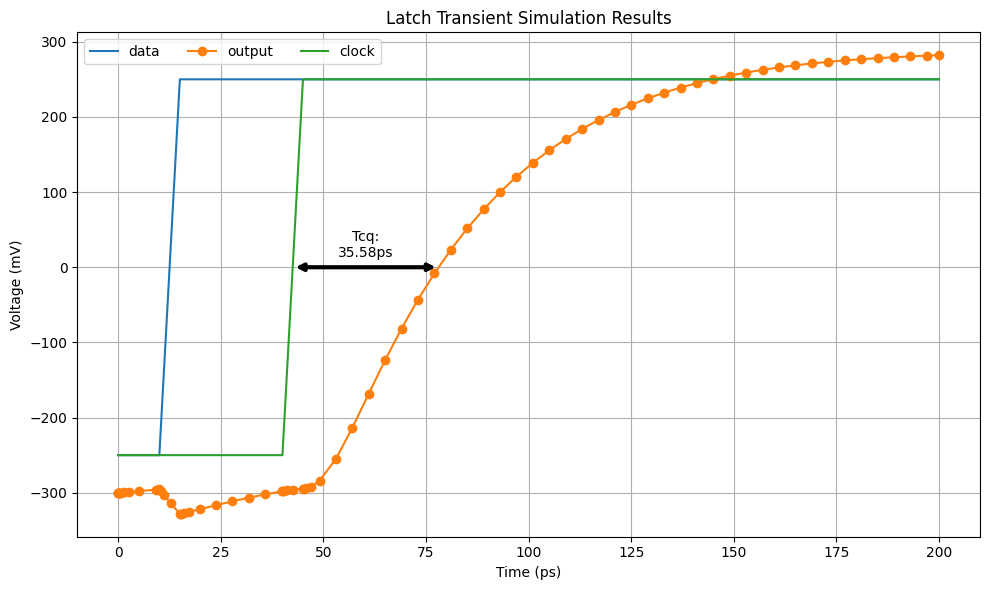

In [194]:
vsw_out = 0.3
vsw_in = 0.25
vsw_clk = 0.25
tcq = 30e-12
cload = 100e-15
av_latch_min = 1.3
vsr_min = 95

problem = LatchProblem(vsw_out, vsw_in, vsw_clk, tcq, cload, av_latch_min, vsr_min)
res = minimize(problem, algorithm, seed=1, verbose=False)
# print solution
print(f"Feasible?: {res.opt is not None}")
if res.opt is not None:
    x = res.X
    iss = res.F
    latch = latch_total_current(
        {
            "av_in": x[0],
            "av_clk": x[1],
            "av_lat": x[2],
            "vsw": vsw_out,
        },
        vsw_in,
        vsw_clk,
        tcq,
        cload,
    )
    print(f"DOFs: {x}")
    print(f"Iss: {iss}")
    print("Running Simulation...")
    tpd, tran_df = run_latch_tb("test", latch, vsw_in, vsw_clk, cload)
    print(f"Tcq: {tpd*1e12:.2f}ps")
    print(f"Error: {(tpd-tcq)/tcq*100}%")
    # plot transient waveform
    def find_zero_crossing(df, signal_name):
        zero_crossings = np.where(np.diff(np.sign(df[signal_name])))[0]
        idx = zero_crossings[0]
        x1, x2 = df['time'].iloc[idx], df['time'].iloc[idx + 1]
        y1, y2 = df[signal_name].iloc[idx], df[signal_name].iloc[idx + 1]
        zero_crossing_time = x1 - y1 * (x2 - x1) / (y2 - y1)
        return zero_crossing_time
    in_zero_crossing_time = find_zero_crossing(tran_df, 'clk')*1e12
    out_zero_crossing_time = find_zero_crossing(tran_df, 'out')*1e12
    propagation_delay = out_zero_crossing_time - in_zero_crossing_time
    plt.figure(figsize=(10, 6))
    plt.plot(tran_df['time']*1e12, tran_df['in'] *1e3, label="data")
    plt.plot(tran_df['time']*1e12, tran_df['out']*1e3,  marker="o", label="output")
    plt.plot(tran_df['time']*1e12, tran_df['clk']*1e3, label="clock")
    plt.title('Latch Transient Simulation Results')
    plt.xlabel('Time (ps)')
    plt.ylabel('Voltage (mV)')
    plt.grid(True)
    y_position = (tran_df['out'].max() + tran_df['out'].min()) / 2
    plt.annotate(
        '',
        xy=(in_zero_crossing_time, 0),
        xytext=(out_zero_crossing_time, 0),
        arrowprops=dict(arrowstyle='<->', color='black', lw=3)
    )
    plt.text(
        (in_zero_crossing_time + out_zero_crossing_time) / 2,
        10,
        f'Tcq:\n{propagation_delay:.2f}ps',
        ha='center',
        va='bottom',
        color='black'
    )
    plt.legend(loc='best', ncol=3)
    plt.tight_layout()
    plt.show()

## Discover Latch Optimization Space
This step is optional in the flow. Latch tables come pre-packaged in the latch.pkl file.

Running the following cell will recreate the latch tables in this directory and results may be different than what is tested.

**When initially running this notebook is recommended to not recreate latch tables.**
**By default the function call at the bottom of this cell is commented out. This can be uncommented to run latch table generation.**

---



In [ ]:
def discover_latch_space():
    cloads = 10*(np.array(list(range(0,9,2)))+1)*1e-15
    vsws = np.linspace(0.2, 0.4, 6)
    tcqs = 10*(np.array(list(range(5)))+2)*1e-12
    vsw_in = 0.3
    vsw_clk = 0.3
    av_latch_min = 1.2
    vsr_min = 95

    delays = np.zeros((len(tcqs), len(cloads), len(vsws)))
    errors = np.zeros((len(tcqs), len(cloads), len(vsws)))
    isss = np.zeros((len(tcqs), len(cloads), len(vsws)))

    for (i, tcq) in enumerate(tcqs):
        for (j, cload) in enumerate(cloads):
            for (k, vsw) in enumerate(vsws):
                vsw_out = vsw

                problem = LatchProblem(vsw_out, vsw_in, vsw_clk, tcq, cload, av_latch_min, vsr_min)
                res = minimize(problem, algorithm, seed=1, verbose=False)
                if res.opt is not None:
                    x = res.X
                    iss = res.F
                    isss[i,j,k] = iss[0]
                    latch = latch_total_current(
                        {
                            "av_in": x[0],
                            "av_clk": x[1],
                            "av_lat": x[2],
                            "vsw": vsw_out,
                        },
                        vsw_in,
                        vsw_clk,
                        tcq,
                        cload,
                    )
                    idw_list = list([float(idw) for idw in np.round([latch["idw_in"], latch["idw_clk"], latch["idw_lat"]],2)])
                    print(f"tcq: {tcq*1e12:.2f} ps, cload: {cload*1e15:.2f} fF, vsw: {vsw*1e3:.2f} mV -> iss: {iss[0]*1e3:.5f} mA, idws: {idw_list} -> ", end="")
                    delays[i,j,k], _ = run_latch_tb(f"tcq_{int(tcq*1e12)}ps_cload_{int(cload*1e15)}f_vsw_{int(vsw*1e3)}m", latch, vsw_in, vsw_clk, cload)
                    errors[i,j,k] = abs(delays[i,j,k] - tcq)/tcq * 100
                    print(f"delay: {delays[i,j,k]*1e12:.2f} ps, error: {errors[i,j,k]:.2f} %, ")
                else:
                  print(f"tcq: {tcq*1e12:.2f} ps, cload: {cload*1e15:.2f} fF, vsw: {vsw*1e3:.2f} mV -> Failure!!")
                  isss[i,j,k] = np.nan
                  delays[i,j,k] = np.nan
                  errors[i,j,k] = np.nan

    data = {
        "tcqs": tcqs,
        "cloads": cloads,
        "vsws": vsws,
        "delays": delays,
        "errors": errors,
        "isss": isss,
    }

    with open("latch.pkl", "wb") as file:
        pickle.dump(data, file)

# discover_latch_space()

### Read Latch Optimization Table

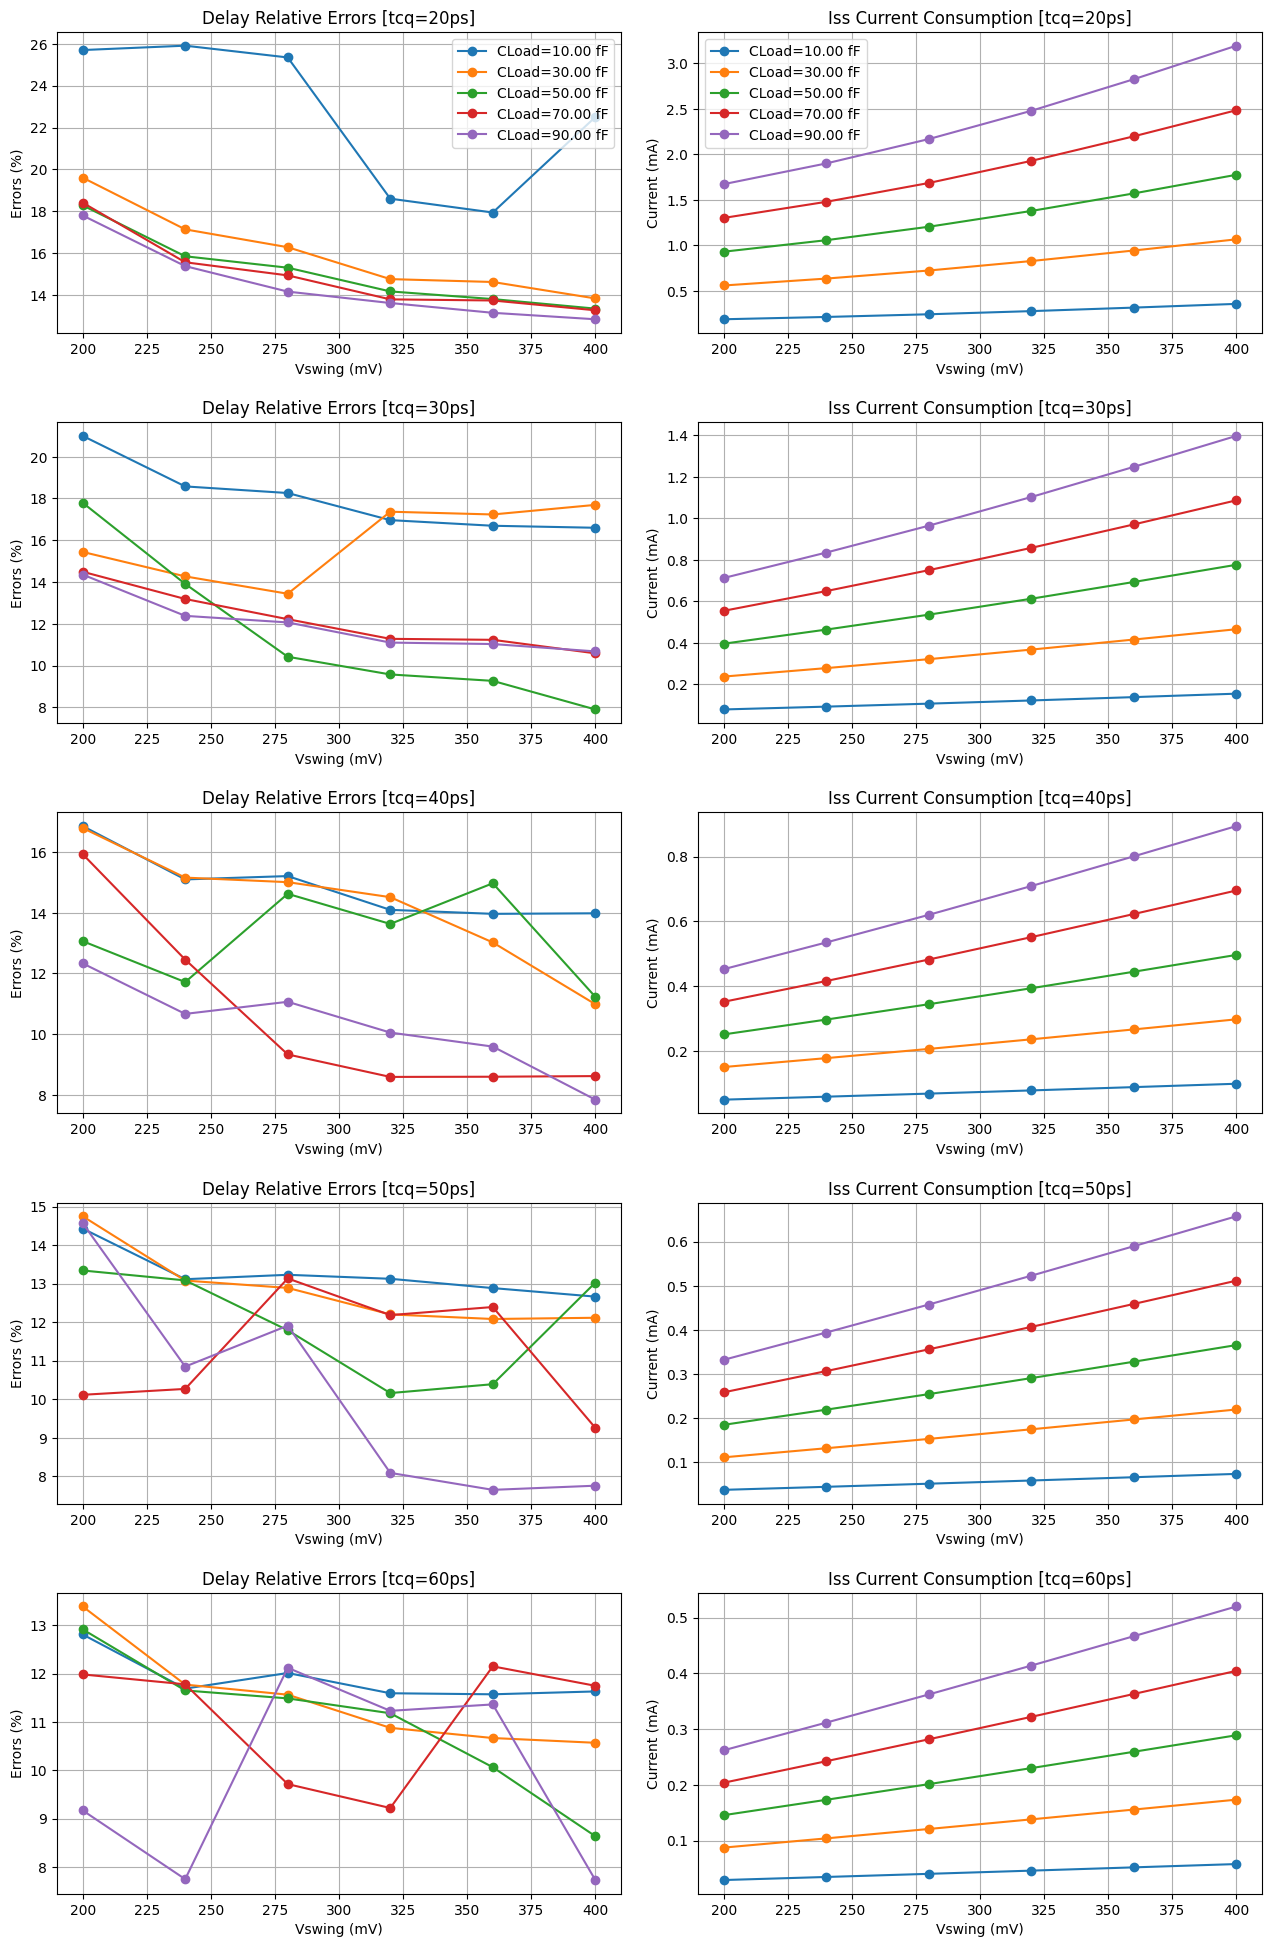

In [ ]:
try:
    with open('latch.pkl', 'rb') as file:
        loaded_data = pickle.load(file)
        tcqs = loaded_data['tcqs']
        cloads = loaded_data['cloads']
        vsws = loaded_data['vsws']
        delays = loaded_data['delays']
        errors = loaded_data['errors']
        isss = loaded_data['isss']
except FileNotFoundError:
    print("Error: 'latch.pkl' not found. Please ensure the file exists.")
except Exception as e:
    print(f"An error occurred during loading: {e}")

# plot data
fig = plt.figure()
dim = int(math.ceil(math.sqrt(tcqs.size)))
for i, tcq in enumerate(tcqs):
    ax1 = fig.add_subplot(tcqs.size, 2, 1+2*i)
    ax2 = fig.add_subplot(tcqs.size, 2, 2+2*i)
    for j, cload in enumerate(cloads):
        ax1.plot(vsws*1e3, errors[i,j,:], marker='o', label=f'CLoad={cload*1e15:.2f} fF')
        ax2.plot(vsws*1e3, isss[i,j,:]*1e3, marker='o', label=f'CLoad={cload*1e15:.2f} fF')
    if i == 0:
      ax1.legend(loc='best')
      ax2.legend(loc='best')
    ax1.set_xlabel("Vswing (mV)")
    ax1.set_ylabel("Errors (%)")
    ax1.set_title(f"Delay Relative Errors [tcq={tcq*1e12:.0f}ps]")
    ax1.grid(True)
    ax2.set_xlabel("Vswing (mV)")
    ax2.set_ylabel("Current (mA)")
    ax2.set_title(f"Iss Current Consumption [tcq={tcq*1e12:.0f}ps]")
    ax2.grid(True)
plt.tight_layout(h_pad=-3.5, w_pad=-2)
plt.subplots_adjust(right=2, top=4)
plt.show()

## 2. CML Divide-by-2: Design and Optimization

The following function defines the objective function from the Divide-by-2 analytical analysis. This function takes values for the Vswing and Av for the devices to be evaluated at. In addition to this it takes the load capacitance and the required max operation frequency.

![image.png](images\divider_tb.png)


In [ ]:
# latch: {"av_in": , "av_clk": , "av_lat": , "vsw": }
# sf: {"gmid": }
def divider_total_current(
    latch1,
    latch2,
    sf,
    vsw_clk,
    max_freq,
    tcq_sf,
    cwire,
    cload,
):

    latch1 = eval_latch_idw(latch1)
    latch2 = eval_latch_idw(latch2)
    sf = eval_sf_idw(sf, latch2["vsw"])

    latch1_vsw = latch1["vsw"]
    latch2_vsw = latch2["vsw"]
    for i in range(5):
        latch1_vsw = np.clip(latch1_vsw, 0.2, 0.4)
        latch2_vsw = np.clip(latch2_vsw, 0.2, 0.4)

        latch1 = eval_latch_vsr(latch1, latch2_vsw, vsw_clk)
        latch2 = eval_latch_vsr(latch2, latch1_vsw, vsw_clk)

        latch1_vsw = latch1["vsw"] * latch1["vsr_in"] * latch1["vsr_clk"] / 10000
        latch2_vsw = latch2["vsw"] * latch2["vsr_in"] * latch2["vsr_clk"] / 10000

    sf = eval_sf_av(sf, latch2["vsw"])

    latch1 = eval_latch_caps(latch1)
    latch2 = eval_latch_caps(latch2)
    sf = eval_sf_caps(sf, latch2["vsw"])

    tcq = 0.5 / max_freq

    sf_cload = 0
    latch1_cload = 0
    latch2_cload = 0
    for i in range(5):
        sf = calc_sf_iss(sf, cwire + cload + sf_cload, tcq_sf)
        latch1 = calc_latch_iss(latch1, cwire + latch1_cload, tcq)
        latch2 = calc_latch_iss(latch2, cwire + latch2_cload, tcq)

        sf_cload = 0
        latch1_cload = (latch2["cgd_in"] + latch2["cgs_in"]) * latch2["iss"]
        latch2_cload = (latch1["cgd_in"] + latch1["cgs_in"]) * latch1["iss"] + (sf["cgd"] + sf["cgs"]) * sf["iss"]

    return latch1, latch2, sf

### Divider Latch Testbench

In [164]:
def run_divider_tb(dirprefix,
    latch1,
    latch2,
    sf,
    vsw_clk,
    cwire,
    cload,
    freq,
):
    latch1_win = round(0.5 * latch1["iss"] / latch1["idw_in"] * 1e6, 2)
    latch1_wclk = round(0.5 * latch1["iss"] / latch1["idw_clk"] * 1e6, 2)
    latch1_wlat = round(0.5 * latch1["iss"] / latch1["idw_lat"] * 1e6, 2)
    latch2_win = round(0.5 * latch2["iss"] / latch2["idw_in"] * 1e6, 2)
    latch2_wclk = round(0.5 * latch2["iss"] / latch2["idw_clk"] * 1e6, 2)
    latch2_wlat = round(0.5 * latch2["iss"] / latch2["idw_lat"] * 1e6, 2)
    sf_w = round(sf["iss"] / sf["idw"] * 1e6, 2)

    src_dir = "divider/"
    dst_dir = f"divider_sim_{dirprefix}/"
    if os.path.exists(dst_dir):
        shutil.rmtree(dst_dir)
    shutil.copytree(src_dir, dst_dir)

    with open(f"{dst_dir}divider_params.cir", "r+") as file:
        netlist = "".join(file.readlines())
        netlist = netlist.replace("$latch1_winp", str(latch1_win))
        netlist = netlist.replace("$latch1_wclk", str(latch1_wclk))
        netlist = netlist.replace("$latch1_wlat", str(latch1_wlat))
        netlist = netlist.replace("$latch1_nfinp", str(max(1, int(latch1_win / 2))))
        netlist = netlist.replace("$latch1_nfclk", str(max(1, int(latch1_wclk / 2))))
        netlist = netlist.replace("$latch1_nflat", str(max(1, int(latch1_wlat / 2))))
        netlist = netlist.replace("$latch1_vsw", str(round(latch1["vsw"] * 1e3, 2)) + "m")
        netlist = netlist.replace("$latch1_iss", str(round(latch1["iss"] * 1e6, 2)) + "u")

        netlist = netlist.replace("$latch2_winp", str(latch2_win))
        netlist = netlist.replace("$latch2_wclk", str(latch2_wclk))
        netlist = netlist.replace("$latch2_wlat", str(latch2_wlat))
        netlist = netlist.replace("$latch2_nfinp", str(max(1, int(latch2_win / 2))))
        netlist = netlist.replace("$latch2_nfclk", str(max(1, int(latch2_wclk / 2))))
        netlist = netlist.replace("$latch2_nflat", str(max(1, int(latch2_wlat / 2))))
        netlist = netlist.replace("$latch2_vsw", str(round(latch2["vsw"] * 1e3, 2)) + "m")
        netlist = netlist.replace("$latch2_iss", str(round(latch2["iss"] * 1e6, 2)) + "u")

        netlist = netlist.replace("$sf_w", str(sf_w))
        netlist = netlist.replace("$sf_nf", str(max(1, int(sf_w / 2))))
        netlist = netlist.replace("$sf_iss", str(round(sf["iss"] * 1e6, 2)) + "u")

        netlist = netlist.replace("$vsw_clk", str(round(vsw_clk * 1e3, 2)) + "m")
        netlist = netlist.replace("$cm_clk", str(round(0.5 * 1e3, 2)) + "m")
        netlist = netlist.replace("$cwire", str(round(cwire * 1e15, 2)) + "f")
        netlist = netlist.replace("$cload", str(round(cload * 1e15, 2)) + "f")

        file.seek(0)
        file.writelines(netlist)
        file.truncate()

    with open(f"{dst_dir}tb_divider.cir", "r+") as file:
        testbench = "".join(file.readlines())
        testbench = testbench.replace("_PDK_ROOT", os.environ["PDK_ROOT"])
        testbench = testbench.replace("_CORNER", "tt")
        testbench = testbench.replace("_VDD", "1.8")
        testbench = testbench.replace("_PERIOD", str(round(1/freq * 1e12, 2)) + "p")
        testbench = testbench.replace("_TRISE", str(round(1/(10*freq) * 1e12, 2)) + "p")
        testbench = testbench.replace("_TSTEP", str(round(1/(10*freq) * 1e12, 2)) + "p")
        testbench = testbench.replace("_TSTOP", str(round(20/freq * 1e12, 2)) + "p")
        file.seek(0)
        file.writelines(testbench)
        file.truncate()

    result = subprocess.run(
        ["ngspice", "-b", "tb_divider.cir"],
        cwd=dst_dir,
        env=os.environ,
        capture_output=True,
        text=True,
    )
    if result.returncode != 0:
      print(result.stderr)
      raise Exception("ngspice failed")

    df = pd.read_csv(
        f"{dst_dir}results.txt",
        sep=r"\s+",
        usecols=[0]+[1+2*i for i in range(2)],
        names=[
            "time",
            "clk",
            "out",
        ],
        skipinitialspace=True,
    )
    shutil.rmtree(dst_dir)
    return df

### Pymoo Optimizater Class

In [ ]:
class DividerProblem(ElementwiseProblem):
    def __init__(self, vsw_clk, max_freq, tcq_sf, cwire, cload, vsw_min, av_latch_min, vsr_min, av_sf_min):
        super().__init__(
            n_var=9,
            n_obj=1,
            n_ieq_constr=6,
            xl=np.array([0.2, vsw_min, 0.5, 0.5, av_latch_min, 0.5, 0.5, av_latch_min, 1]),
            xu=np.array([0.4, 0.4, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 25]),
        )
        self.vsw_clk = vsw_clk
        self.max_freq = max_freq
        self.tcq_sf = tcq_sf
        self.cwire = cwire
        self.cload = cload
        self.vsw_min = vsw_min
        self.av_latch_min = av_latch_min
        self.vsr_min = vsr_min
        self.av_sf_min = av_sf_min

    def _evaluate(self, x, out, *args, **kwargs):
        latch1, latch2, sf = divider_total_current(
            {
                "av_in": x[2],
                "av_clk": x[3],
                "av_lat": x[4],
                "vsw": x[0],
            },
            {
                "av_in": x[5],
                "av_clk": x[6],
                "av_lat": x[7],
                "vsw": x[1],
            },
            {
                "gmid": x[8],
            },
            self.vsw_clk,
            self.max_freq,
            self.tcq_sf,
            self.cwire,
            self.cload,
        )
        out["F"] = [latch1["iss"] + latch2["iss"] + sf["iss"]]
        out["G"] = [
            self.vsr_min - latch1["vsr_in"] * latch1["vsr_clk"] / 100,
            self.vsr_min - latch2["vsr_in"] * latch2["vsr_clk"] / 100,
            self.av_sf_min - sf["av"],
            -latch1["iss"],
            -latch2["iss"],
            -sf["iss"],
        ]


### Pymoo Algorithm

In [ ]:
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=50,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
)

### Optimize and Simulate

Feasible?: True
DOFs: [ 0.28916086  0.30000758  1.49790052  1.66124171  1.52745047  1.58944192
  1.77369862  1.50133444 10.98445254]
Iss: [0.00458592]
Running Simulation...
Freq: 4.00GHz
Error: 50.00%


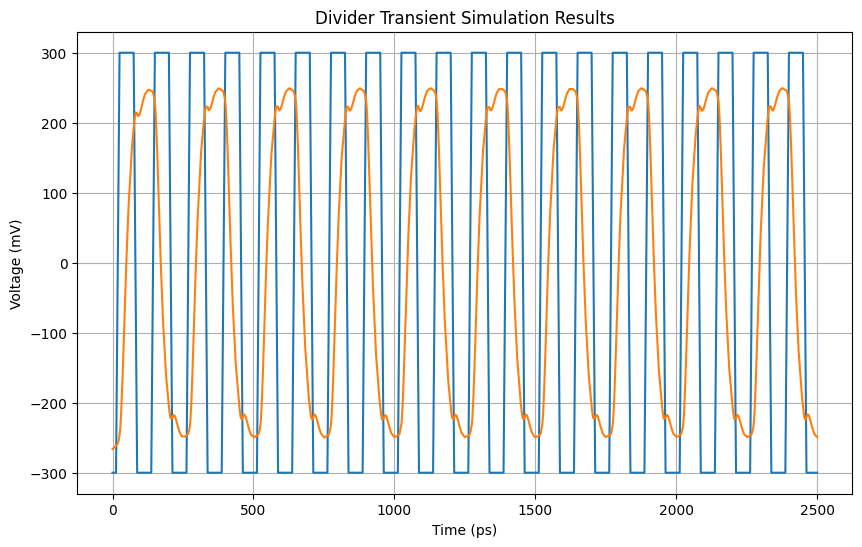

In [195]:
vsw_clk = 0.3
max_freq = 8e9
delay_ratio = 3
tcq_sf = 4e-12
cwire = 20e-15
cload = 100e-15

vsw_min = 0.3
av_latch_min = 1.5
vsr_min = 97
av_sf_min = 0.9

problem = DividerProblem(vsw_clk, max_freq, tcq_sf, cwire, cload, vsw_min, av_latch_min, vsr_min, av_sf_min)
res = minimize(problem, algorithm, seed=1, verbose=False)
# print solution
print(f"Feasible?: {res.opt is not None}")
if res.opt is not None:
    x = res.X
    iss = res.F
    latch1, latch2, sf = divider_total_current(
        {
            "av_in": x[2],
            "av_clk": x[3],
            "av_lat": x[4],
            "vsw": x[0],
        },
        {
            "av_in": x[5],
            "av_clk": x[6],
            "av_lat": x[7],
            "vsw": x[1],
        },
        {
            "gmid": x[8],
        },
        vsw_clk,
        max_freq*delay_ratio,
        tcq_sf,
        cwire,
        cload,
    )
    print(f"DOFs: {x}")
    print(f"Iss: {iss}")
    print("Running Simulation...")
    tran_df = run_divider_tb("test", latch1, latch2, sf, vsw_clk, cwire, cload, max_freq)
    def find_zero_crossings(x, y):
        zero_crossings = []
        sign_changes = np.diff(np.sign(y)) != 0
        for i in np.where(sign_changes)[0]:
            x1, y1 = x[i], y[i]
            x2, y2 = x[i+1], y[i+1]
            if y2 < y1:
                continue
            if y2 - y1 == 0:
                if y1 == 0:
                    zero_crossings.append(x1)
                continue
            x_zero = x1 - y1 * (x2 - x1) / (y2 - y1)
            zero_crossings.append(x_zero)
        return np.array(zero_crossings)
    zero_crossings = find_zero_crossings(tran_df["time"], tran_df["out"])
    meas_freq = np.abs(np.average(1/np.diff(zero_crossings)[-6:-1]))
    print(f"Out Freq: {meas_freq*1e-9:.2f}GHz")
    print(f"Error: {np.abs(max_freq-2*meas_freq)/max_freq*1e6:.2f}ppm")
    plt.figure(figsize=(10, 6))
    plt.plot(tran_df['time']*1e12, tran_df['clk']*1e3, label="clock")
    plt.plot(tran_df['time']*1e12, tran_df['out']*1e3, label="output")
    plt.title('Divider Transient Simulation Results')
    plt.xlabel('Time (ps)')
    plt.ylabel('Voltage (mV)')
    plt.grid(True)

## Discover Divider Sensitivity Curve
This step is optional in the flow. Divider tables come pre-packaged in the latch.pkl file.

Running the following cell will recreate the divider tables in this directory and results may be different than what is tested.

**When initially running this notebook is recommended to not recreate divider tables.**
**By default the function call at the bottom of this cell is commented out. This can be uncommented to run divider table generation.**

---



In [ ]:
def discover_divider_sensitivity():
    freqs = np.array([0.5, 1, 2, 4, 6, 8, 9, 10, 11])*1e9
    vsws = np.array([50, 100, 150, 200, 250, 300])*1e-3

    dfs = []
    out_freqs = np.zeros((len(freqs), len(vsws)))
    errors = np.zeros((len(freqs), len(vsws)))

    for (i, freq) in enumerate(freqs):
        for (j, vsw) in enumerate(vsws):
            print(f"freq: {freq*1e-9:.2f} GHz, vsw: {vsw*1e3:.2f} mV -> ", end="")
            tran_df = run_divider_tb(f"frq_{int(freq*1e-8)}mhz_vsw_{int(vsw*1e3)}m", latch1, latch2, sf, vsw, cwire, cload, freq)
            dfs.append(tran_df)
            def find_zero_crossings(x, y):
                zero_crossings = []
                sign_changes = np.diff(np.sign(y)) != 0
                for i in np.where(sign_changes)[0]:
                    x1, y1 = x[i], y[i]
                    x2, y2 = x[i+1], y[i+1]
                    if y2 < y1:
                        continue
                    if y2 - y1 == 0:
                        if y1 == 0:
                            zero_crossings.append(x1)
                        continue
                    x_zero = x1 - y1 * (x2 - x1) / (y2 - y1)
                    zero_crossings.append(x_zero)
                return np.array(zero_crossings)
            zero_crossings = find_zero_crossings(tran_df["time"], tran_df["out"])
            meas_freq = np.abs(np.average(1/np.diff(zero_crossings)[-6:-1]))
            out_freqs[i,j] = meas_freq
            errors[i,j] = np.abs(freq-2*meas_freq)/freq
            print(f"out freq: {meas_freq*1e-9:.2f} GHz, error: {np.abs(freq-2*meas_freq)/freq*1e6:.2f} ppm")

    data = {
        "freqs": freqs,
        "vsws": vsws,
        "out_freqs": out_freqs,
        "errors": errors,
    }

    with open("divider.pkl", "wb") as file:
        pickle.dump(data, file)

# discover_divider_sensitivity()

freq: 0.50 GHz, vsw: 50.00 mV -> 

## TODO

I have yet to draw the sensitivty curve and optimize the divider 2/3. I have the code but didn't have time to put it.